In [1]:
import numpy as np
import os

# this is for loading the data
def load_fall_X(file_name):
    temp = np.memmap(file_name, dtype='float32', mode='r')
    X = np.reshape(temp, [-1, 256, 6])
    return X

# this is for loading the labels (one-hot encoding: [1, 0, 0]-->nonfall, [0, 1, 0]-->pre-impact fall, [0, 0, 1]-->fall	
def load_fall_y(file_name):
    temp = np.memmap(file_name, dtype='int8', mode='r')
    y= np.reshape(temp, [-1, 3])
    return y

def dset_fpath(fname):
    _fp = os.path.abspath('.')
    _hp = "wobblewatch"
    _fp = _fp.split(_hp)[0]
    return os.path.abspath("%s/%s/data/sisfall/preproc/%s" % (_fp, _hp, fname))

In [2]:
test  = {'X': {}, 'y': {}}
train = {'X': {}, 'y': {}}
for i in range(5):
    test['X'][i] = load_fall_X(dset_fpath("test_x_%i" % i))
    test['y'][i] = load_fall_y(dset_fpath("test_y_%i" % i))
    train['X'][i] = load_fall_X(dset_fpath("train_x_%i" % i))
    train['y'][i] = load_fall_y(dset_fpath("train_y_%i" % i))

In [3]:
for i in range(5):
    print("Set", i)
    print(" X train shape:", train['X'][i].shape)
    print(" y train shape:", train['y'][i].shape)
    print(" X test shape: ", test['X'][i].shape)
    print(" y test shape: ", test['y'][i].shape)

Set 0
 X train shape: (75025, 256, 6)
 y train shape: (75025, 3)
 X test shape:  (19064, 256, 6)
 y test shape:  (19064, 3)
Set 1
 X train shape: (73347, 256, 6)
 y train shape: (73347, 3)
 X test shape:  (20742, 256, 6)
 y test shape:  (20742, 3)
Set 2
 X train shape: (73534, 256, 6)
 y train shape: (73534, 3)
 X test shape:  (20555, 256, 6)
 y test shape:  (20555, 3)
Set 3
 X train shape: (77296, 256, 6)
 y train shape: (77296, 3)
 X test shape:  (16793, 256, 6)
 y test shape:  (16793, 3)
Set 4
 X train shape: (77154, 256, 6)
 y train shape: (77154, 3)
 X test shape:  (16935, 256, 6)
 y test shape:  (16935, 3)


In [ ]:
train['y']

In [ ]:
y = train['y'][0]
print(y)
y[y[:,0] == 0]

In [ ]:
import matplotlib.pyplot as plt

setnum = 0


col_start = {"acc": 0, "rot": 3}
col = col_start['rot']
X, y = train['X'][setnum], train['y'][setnum]
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)
labeli = 1
labelj = 1
X_fpf, y_fpf = X[y[:,labeli] == labelj], y[y[:,labeli] == labelj]
print(X_fpf.shape, y_fpf.shape)

# for index in range(len(X_fpf)):
for index in range(5):
    _X = X[index]
#     print(_X.shape)
    plt.plot(_X[:,col])
    plt.plot(_X[:,col+1])
    plt.plot(_X[:,col+2])
    plt.show()
    
X_fpf, y_fpf = X[y[:,0] == 0], y[y[:,0] == 0]

In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow_addons import losses 
import matplotlib.pyplot as plt


n_timesteps = 256
n_features = 6
n_outputs = 3

def hybrid_model():
    model = models.Sequential()
    # First CNN layer
    model.add(layers.Conv1D(kernel_size=3, 
                            filters=64, 
                            activation='relu', 
                            input_shape=(n_timesteps, n_features)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(2))
    # Second CNN layer
    model.add(layers.Conv1D(kernel_size = 3, 
                            filters = 64, 
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(2))
    # Third CNN layer
    model.add(layers.Conv1D(kernel_size = 3, 
                            filters = 64, 
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(2))
    # Fourth CNN layer
    model.add(layers.Conv1D(kernel_size = 3, 
                            filters = 64, 
                            activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling1D(2))
    # LSTM Layers
    model.add(layers.Dense(32))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    # First LSTM
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.Dropout(0.5))
    # Second LSTM
    model.add(layers.LSTM(32, return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(n_outputs, activation='softmax'))
    print(model.summary())
    opt = optimizers.Adam(learning_rate=0.0005)
    lss = losses.SigmoidFocalCrossEntropy()
    model.compile(loss=lss, optimizer=opt, metrics=['accuracy'])    

#     model.compile(loss=focal_loss(alpha=1), optimizer='nadam', metrics=['accuracy'])
    
    return model

## Next I run the 5-fold cross-validation.

In [5]:
n_folds = 5
n_epochs = 20
batch_size = 64
history = {}
mod = {}
for fold in range(n_folds):
    X_train, y_train = train['X'][fold], train['y'][fold]
    X_test,  y_test  =  test['X'][fold],  test['y'][fold]
    mod[fold] = hybrid_model()
    history[fold] = mod[fold].fit(train['X'][fold], train['y'][fold], 
                                  validation_data=(test['X'][fold], test['y'][fold]), 
                                  epochs = n_epochs, batch_size = batch_size )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 254, 64)           1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 64)           256       
_________________________________________________________________
re_lu (ReLU)                 (None, 254, 64)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 127, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 125, 64)           0

1147/1147 [==============================] - 72s 62ms/step - loss: 0.0226 - accuracy: 0.9723 - val_loss: 0.0191 - val_accuracy: 0.9766
Epoch 2/20
1147/1147 [==============================] - 71s 62ms/step - loss: 0.0159 - accuracy: 0.9793 - val_loss: 0.0162 - val_accuracy: 0.9797
Epoch 3/20
1147/1147 [==============================] - 70s 61ms/step - loss: 0.0136 - accuracy: 0.9806 - val_loss: 0.0187 - val_accuracy: 0.9701
Epoch 4/20
1147/1147 [==============================] - 70s 61ms/step - loss: 0.0125 - accuracy: 0.9815 - val_loss: 0.0149 - val_accuracy: 0.9799
Epoch 5/20
1147/1147 [==============================] - 71s 62ms/step - loss: 0.0117 - accuracy: 0.9826 - val_loss: 0.0161 - val_accuracy: 0.9763
Epoch 6/20
1147/1147 [==============================] - 70s 61ms/step - loss: 0.0112 - accuracy: 0.9827 - val_loss: 0.0155 - val_accuracy: 0.9811
Epoch 7/20
1147/1147 [==============================] - 69s 60ms/step - loss: 0.0105 - accuracy: 0.9835 - val_loss: 0.0151 - val_accura

1149/1149 [==============================] - 66s 57ms/step - loss: 0.0090 - accuracy: 0.9854 - val_loss: 0.0150 - val_accuracy: 0.9856
Epoch 13/20
1149/1149 [==============================] - 70s 60ms/step - loss: 0.0088 - accuracy: 0.9859 - val_loss: 0.0147 - val_accuracy: 0.9854
Epoch 14/20
1149/1149 [==============================] - 69s 60ms/step - loss: 0.0087 - accuracy: 0.9864 - val_loss: 0.0126 - val_accuracy: 0.9847
Epoch 15/20
1149/1149 [==============================] - 67s 58ms/step - loss: 0.0082 - accuracy: 0.9866 - val_loss: 0.0149 - val_accuracy: 0.9843
Epoch 16/20
1149/1149 [==============================] - 69s 60ms/step - loss: 0.0083 - accuracy: 0.9870 - val_loss: 0.0124 - val_accuracy: 0.9858
Epoch 17/20
1149/1149 [==============================] - 67s 58ms/step - loss: 0.0079 - accuracy: 0.9880 - val_loss: 0.0141 - val_accuracy: 0.9834
Epoch 18/20
1149/1149 [==============================] - 68s 59ms/step - loss: 0.0075 - accuracy: 0.9878 - val_loss: 0.0167 - val_

1206/1206 [==============================] - 50s 42ms/step - loss: 0.0234 - accuracy: 0.9733 - val_loss: 0.0160 - val_accuracy: 0.9796
Epoch 2/20
1206/1206 [==============================] - 49s 41ms/step - loss: 0.0160 - accuracy: 0.9795 - val_loss: 0.0213 - val_accuracy: 0.9661
Epoch 3/20
1206/1206 [==============================] - 49s 41ms/step - loss: 0.0138 - accuracy: 0.9801 - val_loss: 0.0157 - val_accuracy: 0.9783
Epoch 4/20
1206/1206 [==============================] - 49s 41ms/step - loss: 0.0125 - accuracy: 0.9811 - val_loss: 0.0149 - val_accuracy: 0.9765
Epoch 5/20
1206/1206 [==============================] - 49s 41ms/step - loss: 0.0118 - accuracy: 0.9822 - val_loss: 0.0161 - val_accuracy: 0.9745
Epoch 6/20
1206/1206 [==============================] - 49s 41ms/step - loss: 0.0110 - accuracy: 0.9833 - val_loss: 0.0240 - val_accuracy: 0.9559
Epoch 7/20
1206/1206 [==============================] - 49s 41ms/step - loss: 0.0107 - accuracy: 0.9837 - val_loss: 0.0136 - val_accura

In [6]:
for fold in mod:
    test_loss, test_acc = mod[fold].evaluate(test['X'][fold], test['y'][fold], verbose = 2)

596/596 - 5s - loss: 0.0151 - accuracy: 0.9856
649/649 - 6s - loss: 0.0150 - accuracy: 0.9809
643/643 - 6s - loss: 0.0140 - accuracy: 0.9803
525/525 - 5s - loss: 0.0128 - accuracy: 0.9837
530/530 - 5s - loss: 0.0165 - accuracy: 0.9825


In [ ]:
a = np.array([1,2,3,4])
b = np.array([5,6,7,8])
c = np.array([9,10,11,12])
l = [a,b,c]
np.mean(l, axis=0)

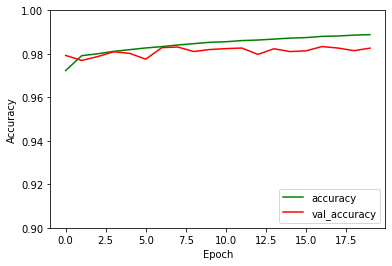

In [11]:
acc,vacc = [],[]
for fold in history:
    acc.append(history[fold].history['accuracy'])
    vacc.append(history[fold].history['val_accuracy'])
plt.plot(np.mean(acc, axis=0), label='accuracy', color='green')
plt.plot(np.mean(vacc, axis=0), label = 'val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend(loc='lower right')
plt.show()

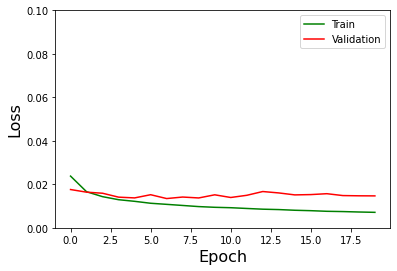

In [10]:
loss,vloss = [],[]
for fold in history:
    loss.append(history[fold].history['loss'])
    vloss.append(history[fold].history['val_loss'])
    
plt.plot(np.mean(loss, axis=0), label='Train', color='green')
plt.plot(np.mean(vloss, axis=0), label='Validation', color='red')
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.ylim([0., 0.1])
plt.legend(loc='upper right')
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
# X_train, y_train = train['X'][fold], train['y'][fold]
# X_test,  y_test  =  test['X'][fold],  test['y'][fold]
ypm, ytm = [], []
for fold in mod:
    y_pred = mod[fold].predict(test['X'][fold])
    y_pred_max = np.argmax(y_pred, axis=1)
    y_test_max = np.argmax(test['y'][fold], axis=1)
    if len(ypm) == 0:
        ypm = y_pred_max
        ytm = y_test_max
    else:
        ypm = np.concatenate((ypm,y_pred_max))
        ytm = np.concatenate((ytm,y_test_max))
    print(y_pred.shape, y_pred_max.shape, y_test_max.shape)
#    confusion_matrix(y_test_max, y_pred_max)
    print(classification_report(y_test_max, y_pred_max, target_names=['no fall', 'pre-fall', 'fall']))
print("\nOverall\n")
print(classification_report(ytm, ypm, target_names=['no fall', 'pre-fall', 'fall']))
print(confusion_matrix(y_test_max, y_pred_max))

(19064, 3) (19064,) (19064,)
              precision    recall  f1-score   support

     no fall       0.99      1.00      0.99     18681
    pre-fall       0.63      0.28      0.39       233
        fall       0.79      0.72      0.75       150

    accuracy                           0.99     19064
   macro avg       0.80      0.67      0.71     19064
weighted avg       0.98      0.99      0.98     19064

(20742, 3) (20742,) (20742,)
              precision    recall  f1-score   support

     no fall       0.99      0.99      0.99     20286
    pre-fall       0.34      0.23      0.28       239
        fall       0.83      0.65      0.73       217

    accuracy                           0.98     20742
   macro avg       0.72      0.62      0.66     20742
weighted avg       0.98      0.98      0.98     20742

(20555, 3) (20555,) (20555,)
              precision    recall  f1-score   support

     no fall       0.99      0.99      0.99     20169
    pre-fall       0.34      0.48      0.4

## Metrics for classification

\begin{align}
\text{Sensitivity} &= \frac{\text{TP}}{\text{TP} + \text{FN}} \\
\text{Specificity} &= \frac{\text{TN}}{\text{TN} + \text{FP}} \\
\text{Accuracy} &= \frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{TN} + \text{FN}} \\
\end{align}

In [13]:
def truth_test(_test,_pred, i):
    _test = np.array(_test)
    _pred = np.array(_pred)
    
    _pred_pos = _test[_pred == i]
    _pred_neg = _test[_pred != i]
    
    _true_pos = len(_pred_pos[_pred_pos == i])
    _fals_pos = len(_pred_pos[_pred_pos != i])
    
    _true_neg = len(_pred_neg[_pred_neg != i])
    _fals_neg = len(_pred_neg[_pred_neg == i])
    
    return _true_pos, _fals_pos, _true_neg, _fals_neg

def sensitivity(_test,_pred, i):
    tp, fp, tn, fn = truth_test(_test, _pred, i)
    return tp / ( tp + fn)

def specificity(_test,_pred, i):
    tp, fp, tn, fn = truth_test(_test, _pred, i)
    return tn / ( tn + fp)

def accuracy(_test, _pred, i):
    tp, fp, tn, fn = truth_test(_test, _pred, i)
    return (tp+tn) / (tp + fp + tn + fn)

for i in range(3):
    print(" Label", i)
    print("    accuracy\t%5.3f"%accuracy(ytm, ypm, i))
    print(" specificity\t%5.3f"%specificity(ytm, ypm, i))
    print(" sensitivity\t%5.3f"%sensitivity(ytm, ypm, i))

 Label 0
    accuracy	0.983
 specificity	0.488
 sensitivity	0.993
 Label 1
    accuracy	0.987
 specificity	0.995
 sensitivity	0.311
 Label 2
    accuracy	0.995
 specificity	0.998
 sensitivity	0.686


In [18]:
from tensorflow.keras.models import model_from_json
import h5py
# serialize model to JSON
model_path = os.path.abspath("../../models/model_hybrid_20")
model_json = mod[3].to_json()
with open(model_path+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
mod[3].save_weights(model_path+".h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import keras
model_path = os.path.abspath("../../models/")
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
plt.imshow([[20047,    72,    50],
            [  150,    48,     4],
            [   47,     1,   136]])